<a href="https://colab.research.google.com/github/tahminehladi/Mental_Health_NLP_Sentiment_/blob/main/Mental_Health_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#import zipfile

#zip_file_path='/content/drive/MyDrive/TensorFlow_data/Combined Data.csv.zip'

#with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#  zip_ref.extractall('/content/drive/MyDrive/TensorFlow_data/Combined Data')

In [3]:
# !unzip '/content/drive/MyDrive/TensorFlow_data/Combined Data.csv.zip' -d '/content/drive/MyDrive/TensorFlow_data/Combined Data'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')


In [5]:
df=pd.read_csv(r'/content/drive/MyDrive/TensorFlow_data/Combined Data/Combined Data.csv',
               index_col=0
               )
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [7]:
df.describe()

,statement,status
count,52681,53043
unique,51073,7
top,what do you mean?,Normal
freq,22,16351


In [8]:
df.isnull().sum()

,0
statement,362
status,0


In [9]:
df.dropna(inplace=True)
df.isnull().sum()

,0
statement,0
status,0


In [10]:
df['status'].value_counts()

,count
status,
Normal,16343
Depression,15404
Suicidal,10652
Anxiety,3841
Bipolar,2777
Stress,2587
Personality disorder,1077


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Normal'),
  Text(1, 0, 'Depression'),
  Text(2, 0, 'Suicidal'),
  Text(3, 0, 'Anxiety'),
  Text(4, 0, 'Bipolar'),
  Text(5, 0, 'Stress'),
  Text(6, 0, 'Personality disorder')])

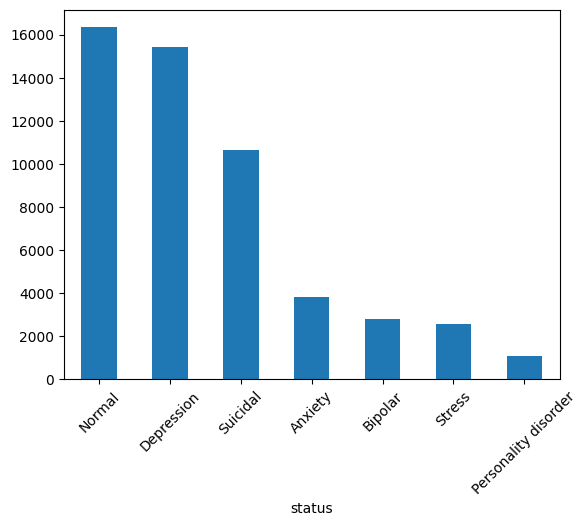

In [11]:
df['status'].value_counts().plot(kind='bar')
plt.xticks(rotation=45)

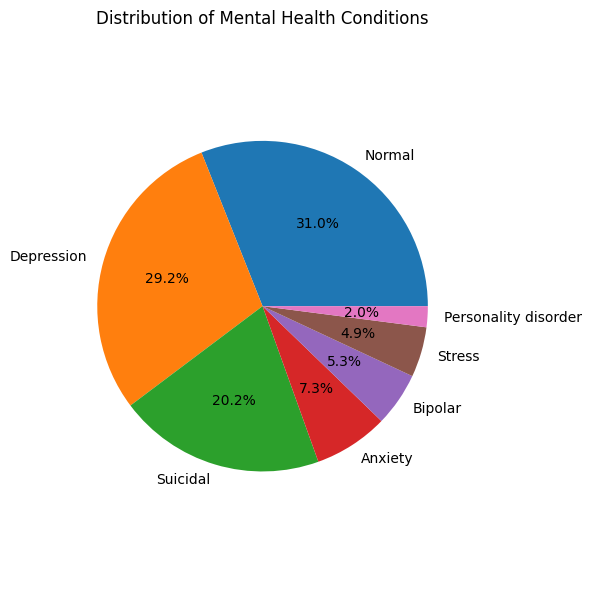

In [12]:
status_counts=df.status.value_counts()
plt.figure(figsize=(6,6))
plt.pie(status_counts,labels=status_counts.index, autopct='%1.1f%%',
        )

plt.title('Distribution of Mental Health Conditions')
plt.axis('equal')

plt.tight_layout()
plt.show()

In [13]:
# Group by status and get a random statement from each group
random_rows=df.groupby('status')['statement'].apply(lambda x: x.sample(n=1).iloc[0])

for status, statement in random_rows.items():
  print(f'Status: {status}')
  print(f'Statement: {statement}\n')

Status: Anxiety
Statement: Anyone felt like this? So first off, I apologize for the millionth post about “has anyone felt like this”. Been struggling to post anything for that reason. I’ve been having really bad anxiety these past 2-3 months. My dad passed away in December and I had to put my dog down a week ago so I definitely think this has affected my greatly. I’ve never felt this “bad” for this long. Been waking up most days shakey and nervous. Most days I’m worrying about my health and can’t seem to shake off intrusive thoughts. I went to the Doctor on Thursday and was told my blood pressure was high, which made me more anxious. Was precribed some for blood pressure and sertraline for the anxiety. Today I’ve been feeling dizzy, it comes and goes and just loosing interest in normal things. Just a general feeling of feeling off or not all here. Also can’t seem to swallow very well. 

I’m starting to exercise more and eating healthier. I’m hoping to see if anyone has any words of enc

In [14]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('punkt.pickle')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Error loading punkt.pickle: Package 'punkt.pickle' not
[nltk_data]     found in index


False

In [15]:
# number of charecters and sentences
df['num_charaters']=df.statement.str.len()

# Add a column with the number of sentences in each statement
df['num_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))


description=df[['num_charaters', 'num_sentences']].describe()
description

,num_charaters,num_sentences
count,52681.000000,52681.000000
mean,578.713863,6.280215
std,846.269078,10.688388
min,2.000000,1.000000
25%,80.000000,1.000000
50%,317.000000,3.000000
75%,752.000000,8.000000
max,32759.000000,1260.000000


In [16]:
df.head()

,statement,status,num_charaters,num_sentences
0,oh my gosh,Anxiety,10,1
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2
3,I've shifted my focus to something else but I'...,Anxiety,61,1
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2


In [17]:
# lowercasing
df.rename(columns={'statement': 'original_statement'}, inplace=True)
df['statement']=df.original_statement.str.lower()
df.head()

,original_statement,status,num_charaters,num_sentences,statement
0,oh my gosh,Anxiety,10,1,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,"trouble sleeping, confused mind, restless hear..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,"all wrong, back off dear, forward doubt. stay ..."
3,I've shifted my focus to something else but I'...,Anxiety,61,1,i've shifted my focus to something else but i'...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,"i'm restless and restless, it's been a month n..."


In [18]:
#Removing URLs, handles, punctuation and special characters
def remove_patterns(text):
  text= re.sub(r'http\S+|www\S+|https\S+','', text)
  text=re.sub(r'\[.*?\]\(.*?\)', '', text)
  text=re.sub(r'@\w+', '', text)
  text=re.sub(r'[^\w\s]', '', text)

  return text.strip()

df['statement']=df.statement.apply(remove_patterns)
df.head()


,original_statement,status,num_charaters,num_sentences,statement
0,oh my gosh,Anxiety,10,1,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...


In [19]:
# let's use word_tokenize to split the text into a list of words (tokens).
df['tokens']=df['statement'].apply(word_tokenize)
df.head()

,original_statement,status,num_charaters,num_sentences,statement,tokens
0,oh my gosh,Anxiety,10,1,oh my gosh,"[oh, my, gosh]"
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ..."
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...,"[ive, shifted, my, focus, to, something, else,..."
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...,"[im, restless, and, restless, its, been, a, mo..."


# Stemming:
Reduce words to their base of root form.

In [20]:
stemmer=PorterStemmer()

def stem_tokens(tokens):
  return ' '.join(stemmer.stem(str(token)) for token in tokens)

df['tokens_stemmed']=df.tokens.apply(stem_tokens)
df.head()

,original_statement,status,num_charaters,num_sentences,statement,tokens,tokens_stemmed
0,oh my gosh,Anxiety,10,1,oh my gosh,"[oh, my, gosh]",oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ...",troubl sleep confus mind restless heart all ou...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ...",all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...,"[ive, shifted, my, focus, to, something, else,...",ive shift my focu to someth els but im still w...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...,"[im, restless, and, restless, its, been, a, mo...",im restless and restless it been a month now b...


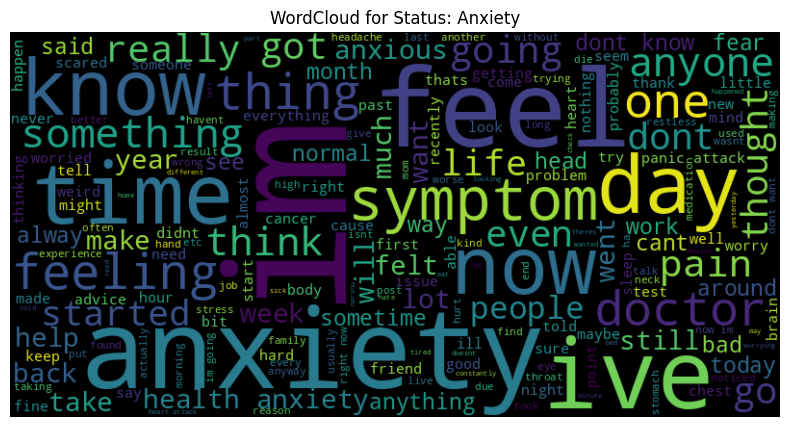

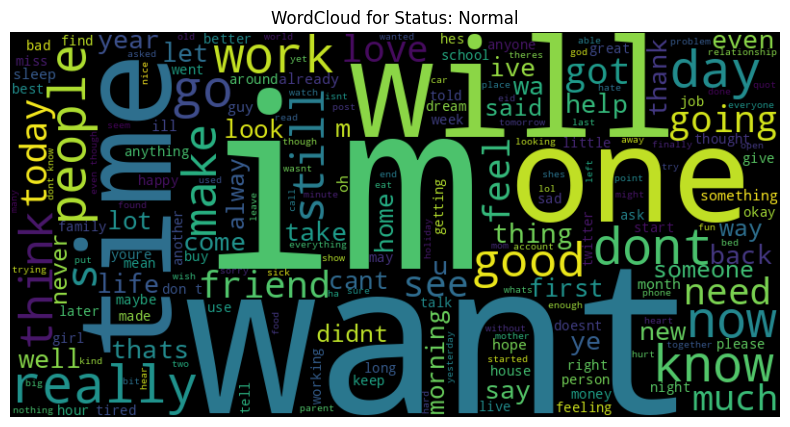

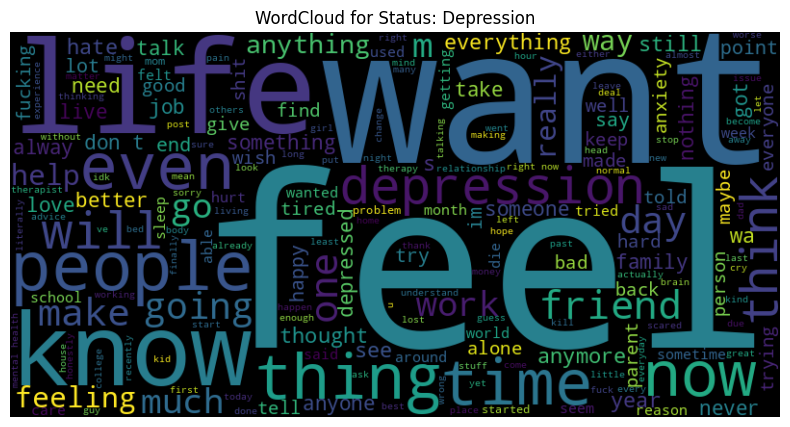

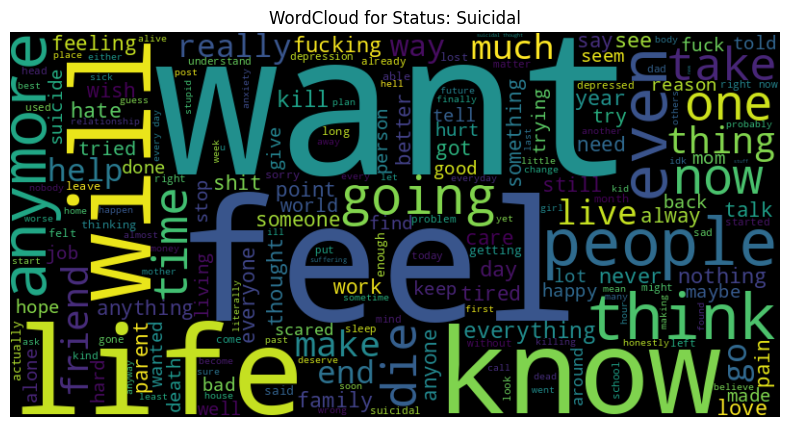

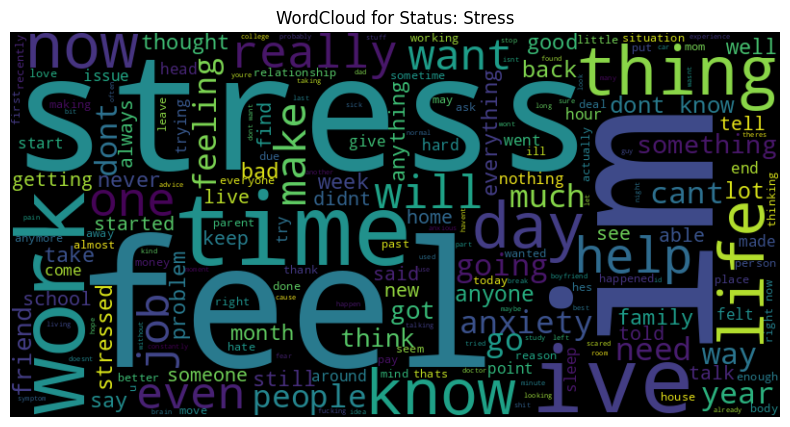

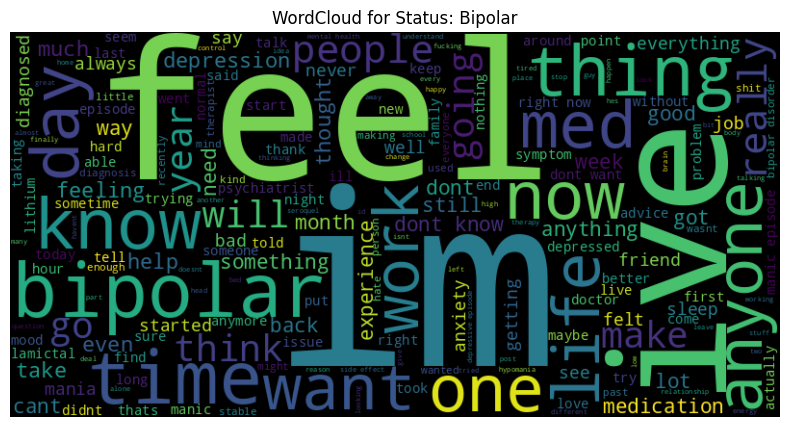

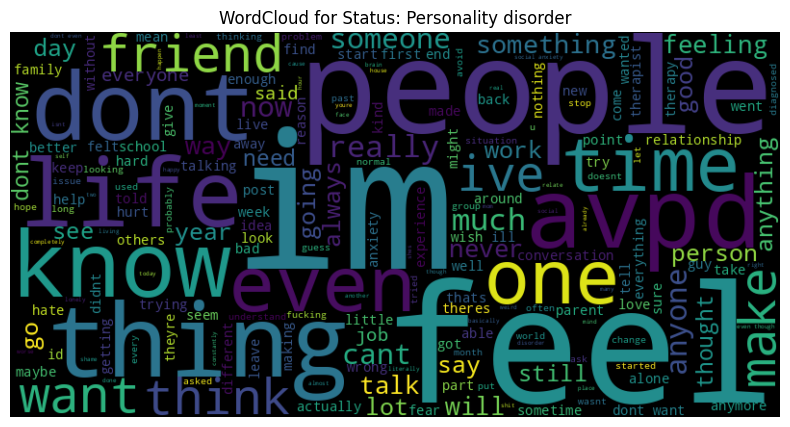

In [21]:
statuses=df.status.unique()

for status in statuses:
  tokens_data=' '.join(df[df['status']==status]
                       ['tokens'].dropna().apply(lambda x: ' '.join(x)).tolist())
  wordcloud=WordCloud(width=800, height=400).generate(tokens_data)

  plt.figure(figsize=(10,5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'WordCloud for Status: {status}')
  plt.show()


In [22]:
# Seperate features and labels

X=df[['tokens_stemmed', 'num_charaters', 'num_sentences']]
y=df['status']

In [23]:
y.head()

,status
0,Anxiety
1,Anxiety
2,Anxiety
3,Anxiety
4,Anxiety


In [24]:
# label encodingtarget variable
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(y.values)
y

array([0, 0, 0, ..., 0, 0, 0])

In [25]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=42)

In [26]:
# Convert text to features using TF-IDF vectoriser
vectorizer=TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
X_train_tfidf=vectorizer.fit_transform(X_train['tokens_stemmed'])
X_test_tfidf=vectorizer.transform(X_test['tokens_stemmed'])

X_train_num=X_train[['num_charaters', 'num_sentences']].values
X_test_num=X_test[['num_charaters', 'num_sentences']].values

# Combine TF-IDF features with numerical features
X_train_combines=hstack([X_train_tfidf, X_train_num])
X_test_combines=hstack([X_test_tfidf, X_test_num])

X_train_combines.shape, X_test_combines.shape

((36876, 50002), (15805, 50002))

In [27]:
# Apply Random Over-Sampling on the vectorized data

ros=RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled=ros.fit_resample(X_train_combines, y_train)

In [28]:
# Modeling

classifiers={
    'Logistic Regression': LogisticRegression(),
    'Random Forest' : RandomForestClassifier(),
    'XGB': XGBClassifier()
}




For Logistic Regression
Accuracy: 0.3774754824422651
                      precision    recall  f1-score   support

             Anxiety       0.53      0.07      0.13      1134
             Bipolar       0.13      0.31      0.18       814
          Depression       0.35      0.15      0.21      4537
              Normal       0.69      0.83      0.75      4987
Personality disorder       0.07      0.13      0.09       332
              Stress       0.04      0.13      0.06       780
            Suicidal       0.31      0.21      0.25      3221

            accuracy                           0.38     15805
           macro avg       0.30      0.26      0.24     15805
        weighted avg       0.43      0.38      0.37     15805



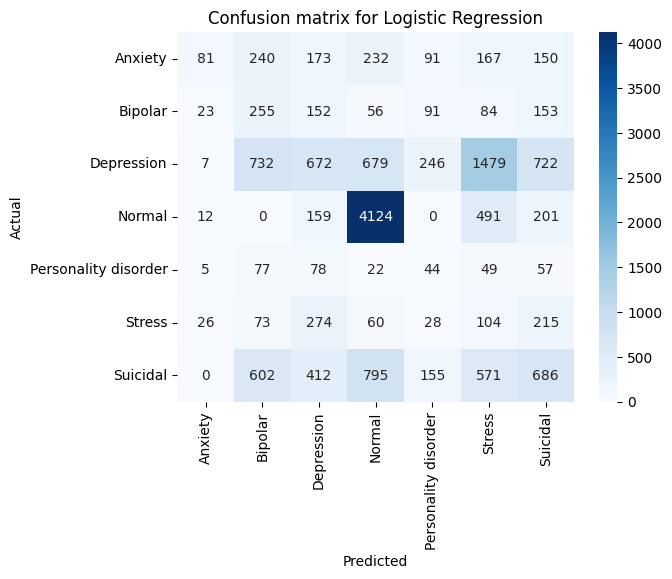



For Random Forest
Accuracy: 0.7370452388484656
                      precision    recall  f1-score   support

             Anxiety       0.80      0.72      0.76      1134
             Bipolar       0.89      0.68      0.77       814
          Depression       0.64      0.73      0.68      4537
              Normal       0.83      0.94      0.88      4987
Personality disorder       0.99      0.33      0.49       332
              Stress       0.76      0.41      0.53       780
            Suicidal       0.66      0.58      0.62      3221

            accuracy                           0.74     15805
           macro avg       0.80      0.62      0.67     15805
        weighted avg       0.74      0.74      0.73     15805



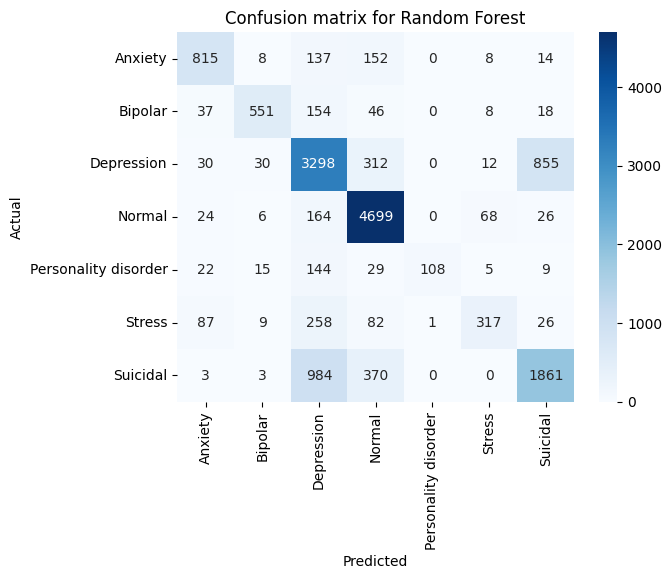



For XGB
Accuracy: 0.7955077507118
                      precision    recall  f1-score   support

             Anxiety       0.83      0.86      0.84      1134
             Bipolar       0.83      0.84      0.83       814
          Depression       0.80      0.67      0.73      4537
              Normal       0.92      0.92      0.92      4987
Personality disorder       0.68      0.75      0.72       332
              Stress       0.59      0.82      0.69       780
            Suicidal       0.67      0.75      0.70      3221

            accuracy                           0.80     15805
           macro avg       0.76      0.80      0.78     15805
        weighted avg       0.80      0.80      0.80     15805



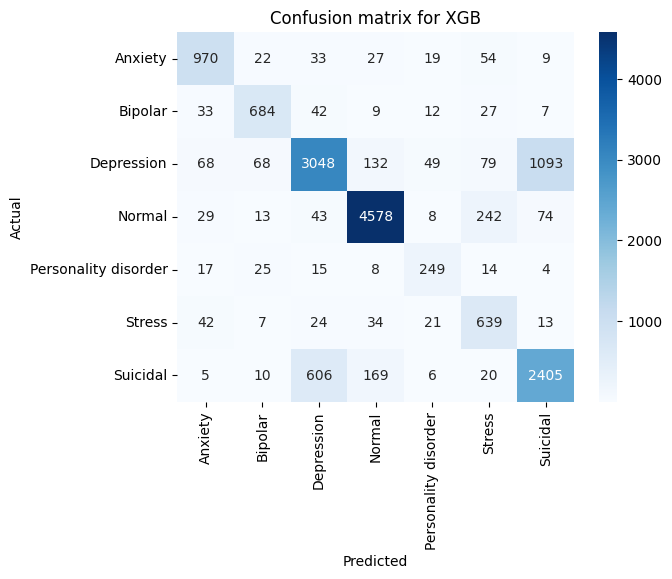

In [29]:
accuracy_scores=[]

for name, clf in classifiers.items():
  clf.fit(X_train_resampled, y_train_resampled)
  y_pred=clf.predict(X_test_combines)
  accuracy=accuracy_score(y_test, y_pred)

  print('\n')
  print( 'For', name)
  print('Accuracy:', accuracy)

  labels=lbl_enc.classes_
  conf_matrix=confusion_matrix(y_test, y_pred)
  print(classification_report(y_test, y_pred, target_names=labels))


  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title(f'Confusion matrix for {name}')
  plt.show()
  accuracy_scores.append(accuracy)

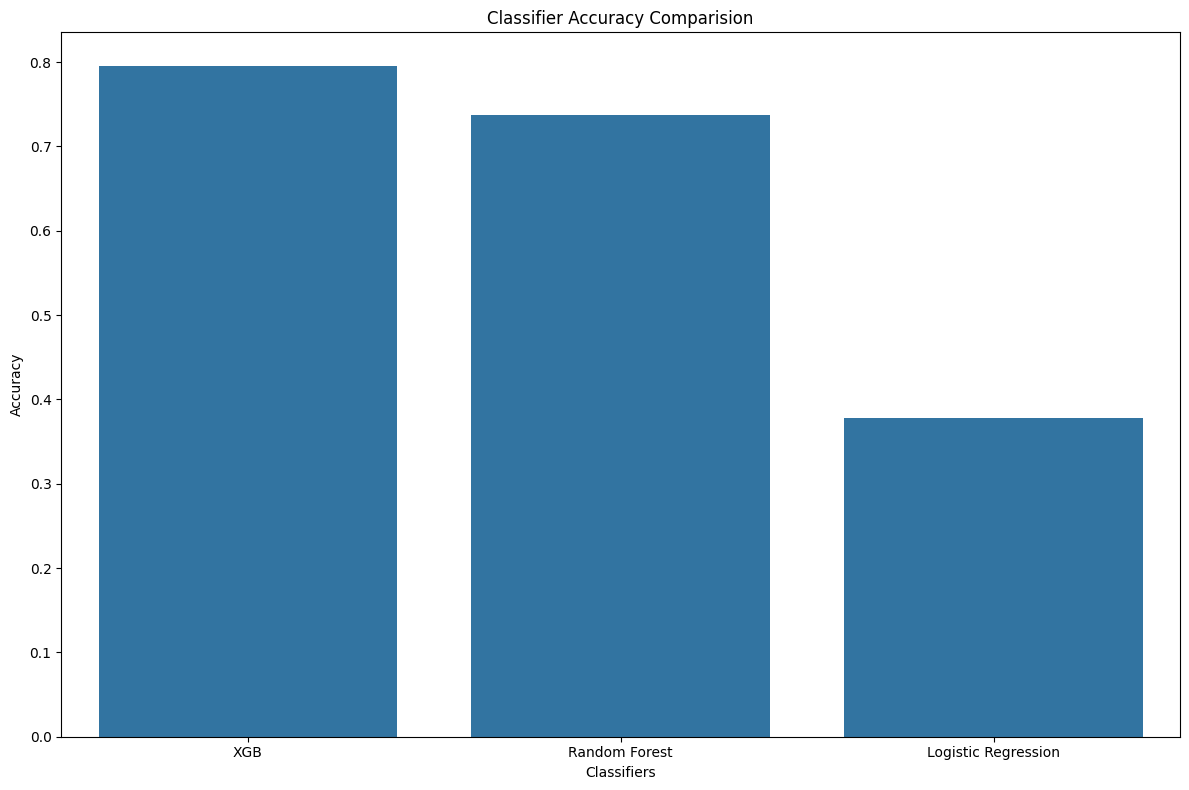

In [30]:
acc_df=pd.DataFrame({'Classifiers': classifiers.keys(),
                   'Accuracy': accuracy_scores}).sort_values('Accuracy', ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(x='Classifiers',
            y='Accuracy',
            data=acc_df)
plt.title('Classifier Accuracy Comparision')
plt.tight_layout()
plt.show()